## Utilities

In [12]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


## Imports

In [13]:
import yaml
import pandas as pd
from tqdm.auto import tqdm
from random import choice
import os
from sklearn.model_selection import train_test_split

In [14]:
from data_preprocessing.text_cleaning import (
    remove_html,
    remove_urls,
    remove_digits,
    remove_punctuation,
    remove_special_characters,
    normalize_whitespace,
    to_lowercase
)
from data_preprocessing.add_domain import add_domain
from data_preprocessing.find_and_remove_duplicates import find_and_remove_dups
from data_preprocessing.balance_data import balance_data, augmentation_threshold

In [1]:
from data_augmentation.paraphrasing import paraphrase
from data_augmentation.style_transfer import transfer_style

In [16]:
from constants import DATASETS

## Load config

In [17]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

## Setup output folder

In [18]:
if not os.path.isdir(config["output"]):
    os.mkdir(config["output"])

## Load Data

In [19]:
data = read_all_datasets()

# -- Orchestration --

## Data Preprocessing

### Find and Remove duplicate Data

In [20]:
datasets = {dataset: read_dataset(dataset) for dataset in DATASETS}
data = find_and_remove_dups(data, datasets)

Total rows                 : 354608
Unique 'text' entries      : 319222
Duplicate 'text' entries   : 35386 (9.98% of total)


==DUPLICATES WITHIN DATASET==
  • Climate-FEVER: 0 duplicates removed, rows 1535→1535 (-0.00%)
  • Fake News Corpus: 7335 duplicates removed, rows 70846→63511 (-10.35%)
  • Fakeddit: 40 duplicates removed, rows 7000→6960 (-0.57%)
  • FakeNewsNet: 1472 duplicates removed, rows 23196→21724 (-6.35%)
  • FEVER: 7518 duplicates removed, rows 109810→102292 (-6.85%)
  • FineFake: 1408 duplicates removed, rows 16909→15501 (-8.33%)
  • LIAR2: 34 duplicates removed, rows 22962→22928 (-0.15%)
  • llm-misinformation: 3034 duplicates removed, rows 7057→4023 (-42.99%)
  • MultiFC: 28 duplicates removed, rows 21148→21120 (-0.13%)
  • Source based FN: 40 duplicates removed, rows 2050→2010 (-1.95%)
  • WELFake: 8456 duplicates removed, rows 72095→63639 (-11.73%)
=> Found 29365 duplicated rows in total


==DUPLICATES ACROSS DATASETS==
  • Climate-FEVER & LIAR2: 25 overlaps (1.63%

### Domain Tagging

Reading saved sentence embeddings...
Initializing KMeans with k=13 Clusters...
Predicting domains with KMeans...
Mapping domain IDs to topic names...
Plotting...


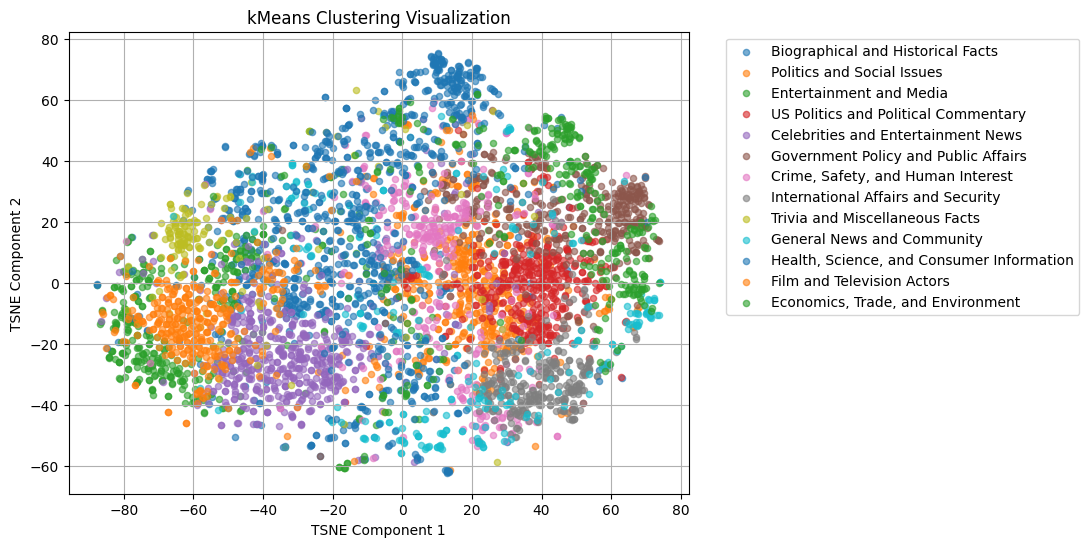



Topic Distribution: domain
Health, Science, and Consumer Information    41445
Celebrities and Entertainment News           33052
US Politics and Political Commentary         28819
Politics and Social Issues                   27474
Biographical and Historical Facts            27135
Entertainment and Media                      24960
Government Policy and Public Affairs         24946
Film and Television Actors                   22815
Crime, Safety, and Human Interest            21505
Economics, Trade, and Environment            21495
International Affairs and Security           18431
General News and Community                   16872
Trivia and Miscellaneous Facts               10273
Name: count, dtype: int64


In [21]:
data = add_domain(data, 
                  k=config["domain_tagging"]["n_domains"],
                  tokenizer_model = config["tokenization"]["tokenizer_model"],
                  save_embeddings=config["domain_tagging"]["save_embeddings"], 
                  use_saved_embeddings=config["domain_tagging"]["use_saved_embeddings"],
                  plot_kmeans=config["domain_tagging"]["plot"])

## Data Augmentation

### Paraphrasing

In [22]:
if config["augmentation"]["paraphrasing"]["enabled"]:
    samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        augmented_texts = []
        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Paraphrasing {n} datapoints from domain '{domain}'...")
        augmented_texts = [paraphrase(text) for text in tqdm(df_domain["text"], desc=f"Paraphrasing '{domain}'", leave=False)]
        
        df_domain["text"] = augmented_texts

        data = pd.concat([data, df_domain], ignore_index=True)

Paraphrasing 1000 datapoints from domain Trivia and Miscellaneous Facts...


Paraphrasing Trivia and Miscellaneous Facts:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Style Transfer

In [29]:
if config["augmentation"]["style_transfer"]["enabled"]:
    samples_to_augment = augmentation_threshold(data, config["augmentation"]["augmentation_budget"])

    target_styles = [
        "Neutral journalistic",
        "Slightly formal",
        "Slightly informal",
        "Objective report",
        "Simplified for general audience",
        "Summarized headline-style",
        "Explanatory tone",
        "SMS/Chat Message Style",
        "Social Media Post",
        "Podcast Transcript Style"
    ]

    for domain, n_samples in samples_to_augment.items():
        if n_samples == 0:
            continue

        augmented_texts = []
        df_domain = data[data["domain"] == domain]
        n = min(n_samples, len(df_domain))
        df_domain = df_domain.sample(n=n).copy()

        print(f"Transfering style for {n} datapoints from domain '{domain}'...")
        augmented_texts = [transfer_style(text, choice(target_styles)) for text in tqdm(df_domain["text"], desc=f"Style Transfer for '{domain}'", leave=False)]

        df_domain["text"] = augmented_texts

        data = pd.concat([data, df_domain], ignore_index=True)

## Data Preprocessing

### Text Cleaning

In [30]:
def clean_text(text, config):
    if config["strip_html"]:
        text = remove_html(text)
    if config["remove_urls"]:
        text = remove_urls(text)
    if config["remove_digits"]:
        text = remove_digits(text)
    if config["remove_punctuation"]:
        text = remove_punctuation(text)
    if config["remove_special_chars"]:
        text = remove_special_characters(text)
    if config["lowercase"]:
        text = to_lowercase(text)
    if config["normalize_whitespace"]:
        text = normalize_whitespace(text)
    
    return text

In [31]:
data["text"] = data["text"].apply(lambda x: clean_text(x, config["preprocessing"]))

### Balancing domain and label

In [32]:
if config["balance_data"]["balance"]:
    data = balance_data(data, tolerance=config["balance_data"]["balance_tolerance"])

## Save Output

In [33]:
data['stratify_key'] = data['label'].astype(str) + "_" + data['domain'].astype(str)


train_val_data, test_data = train_test_split(data, test_size=config["test_size"], stratify=data['stratify_key'])

train_val_data.drop(columns='stratify_key', inplace=True)
test_data.drop(columns='stratify_key', inplace=True)

train_val_data = train_val_data.sample(frac=1.0).reset_index(drop=True)
test_data = test_data.sample(frac=1.0).reset_index(drop=True)

In [34]:
augmented = any([config["augmentation"]["paraphrasing"]["enabled"],
                config["augmentation"]["style_transfer"]["enabled"]])

balanced = config["balance_data"]["balance"]

folder_name = {
    (False, False): 'raw',
    (True,  False): 'balanced',
    (False, True):  'augmented',
    (True,  True):  'balanced_augmented'
}[(balanced, augmented)]

folder_path = os.path.join(config['output'], folder_name)

if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

train_val_data.to_parquet(f"{folder_path}/preprocessed_data_train_val.parquet", index=False)
test_data.to_parquet(f"{folder_path}/preprocessed_data_test.parquet", index=False)